## Problem Statement : 

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

## **Data Dictionary:**

- There are two csv files given

- #### train_1.csv: 
  - In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

  - The page name contains data in this format:

        SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

  - having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)


- #### Exog_Campaign_eng:
  -  This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

  - There’s 1 for dates with campaigns and 0 for remaining dates. 
  - It is to be treated as an exogenous variable for models when training and forecasting data for pages in English


  

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 1000
sns.set(style = 'darkgrid')

- Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset

In [2]:
#Loading the dataset
df = pd.read_csv("C:/Users/USER/Downloads/train_1.csv")

In [3]:
df.shape

(145063, 551)

In [4]:
#Loading the file 
Exog_Campaign_eng = pd.read_csv("C:/Users/USER/Downloads/Exog_Campaign_eng.csv")

In [5]:
Exog_Campaign_eng.shape

(550, 1)

In [6]:
df.Page.sample(20)

84127                                  Help:Contents/ur_www.mediawiki.org_all-access_spider
126118                               Тимберлейк,_Джастин_ru.wikipedia.org_all-access_spider
11740                                         Peppa_Pig_en.wikipedia.org_desktop_all-agents
42743                             Special:CiteThisPage_www.mediawiki.org_desktop_all-agents
98177                           Византийская_империя_ru.wikipedia.org_all-access_all-agents
35270                                        Jenna_Dewan_en.wikipedia.org_all-access_spider
33472                           Kubo_and_the_Two_Strings_en.wikipedia.org_all-access_spider
117292                                 The_Mentalist_de.wikipedia.org_mobile-web_all-agents
124329                                   Стюарт,_Кристен_ru.wikipedia.org_all-access_spider
106719                                         民主進步黨_zh.wikipedia.org_mobile-web_all-agents
28649                                             惠利_zh.wikipedia.org_all-access

In [7]:
df.Page.str.split("_").apply(lambda x:x[3]).head(20)

0               spider
1               spider
2               spider
3               spider
4                 Love
5               spider
6               spider
7               spider
8               spider
9               spider
10              spider
11    zh.wikipedia.org
12                 are
13              spider
14              spider
15              spider
16              spider
17          all-access
18          all-access
19              spider
Name: Page, dtype: object

In [8]:
data = df.copy()

In [9]:
data.duplicated().sum()
# No duplicate data

0

In [10]:
data.dtypes.sample(10)

2015-07-12    float64
2016-05-05    float64
2015-08-03    float64
2015-12-13    float64
2015-08-23    float64
2015-09-22    float64
2015-09-15    float64
2015-10-12    float64
2016-08-23    float64
2016-10-10    float64
dtype: object

In [11]:
indexes = data.head(2).columns[1:][range(0,549,20)].values
indexes

array(['2015-07-01', '2015-07-21', '2015-08-10', '2015-08-30',
       '2015-09-19', '2015-10-09', '2015-10-29', '2015-11-18',
       '2015-12-08', '2015-12-28', '2016-01-17', '2016-02-06',
       '2016-02-26', '2016-03-17', '2016-04-06', '2016-04-26',
       '2016-05-16', '2016-06-05', '2016-06-25', '2016-07-15',
       '2016-08-04', '2016-08-24', '2016-09-13', '2016-10-03',
       '2016-10-23', '2016-11-12', '2016-12-02', '2016-12-22'],
      dtype=object)

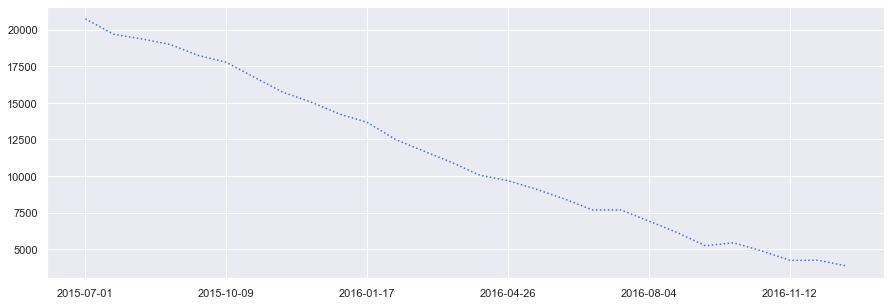

In [13]:
plt.figure(figsize=(15, 5))

data.isna().sum()[indexes].plot(linestyle='dotted')
plt.show()

- from above plot , we can observe that with time , null values are decreasing.
- recent dates have lesser null values
- that means newer pages will have no data of prior to that page hosting date.

In [14]:
# replacing all the null values with 0.
data.fillna(0,inplace =True)

In [15]:
data.isnull().sum()[indexes]


2015-07-01    0
2015-07-21    0
2015-08-10    0
2015-08-30    0
2015-09-19    0
2015-10-09    0
2015-10-29    0
2015-11-18    0
2015-12-08    0
2015-12-28    0
2016-01-17    0
2016-02-06    0
2016-02-26    0
2016-03-17    0
2016-04-06    0
2016-04-26    0
2016-05-16    0
2016-06-05    0
2016-06-25    0
2016-07-15    0
2016-08-04    0
2016-08-24    0
2016-09-13    0
2016-10-03    0
2016-10-23    0
2016-11-12    0
2016-12-02    0
2016-12-22    0
dtype: int64

# Exploratory Analysis : 

##### Extracting Language , access type and access origin -

    The page name contains data in this format:

    SPECIFICNAME_LANGUAGE.wikipedia.org_ACCESS TYPE_ ACCESS ORIGIN

### Extracting Language 

In [16]:
data.Page[0]

'2NE1_zh.wikipedia.org_all-access_spider'

In [17]:
import re
re.findall(r'_(.{2}).wikipedia.org_', "2NE1_zh.wikipedia.org_all-access_spider")

['zh']

In [18]:
data.Page.str.findall(pat="_(.{2}).wikipedia.org_").sample(10)

124657    [ru]
30526     [zh]
10974     [en]
110135    [en]
43282       []
32835     [en]
1957      [zh]
64676     [zh]
28704     [zh]
21063       []
Name: Page, dtype: object

In [19]:
# extracting language 
def Extract_Language(name):
  if len(re.findall(r'_(.{2}).wikipedia.org_', name)) == 1 : 
    return re.findall(r'_(.{2}).wikipedia.org_', name)[0]
  else: 
    return 'Unknown'

In [20]:
data["Language"] = data["Page"].map(Extract_Language)

In [21]:
data["Language"].unique()

array(['zh', 'fr', 'en', 'Unknown', 'ru', 'de', 'ja', 'es'], dtype=object)

https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes

In [22]:
dict_ ={'de':'German',
        'en':'English', 
        'es': 'Spanish', 
        'fr': 'French', 
        'ja': 'Japenese' , 
        'ru': 'Russian', 
        'zh': 'Chinese',
        'Unknown': 'Unknown_Language'}

data["Language"] = data["Language"].map(dict_)

In [23]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

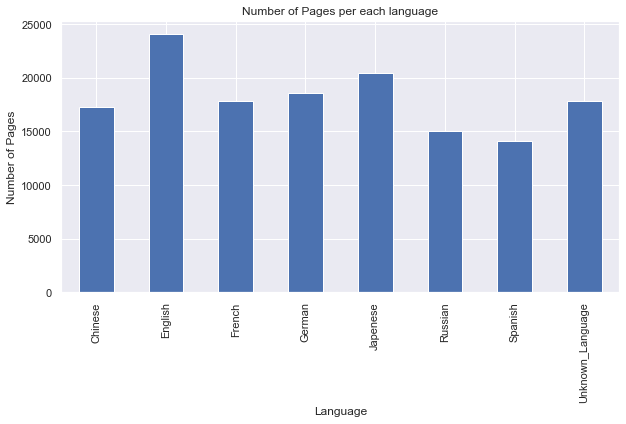

In [24]:
plt.figure(figsize=(10, 5))

data.groupby("Language")["Page"].count().plot(kind="bar")
plt.xlabel("Language")
plt.ylabel("Number of Pages")
plt.title("Number of Pages per each language")
plt.show()

In [25]:
from locale import normalize
data["Language"].value_counts(normalize=True) * 100


English             16.618986
Japenese            14.084225
German              12.785479
Unknown_Language    12.308445
French              12.271909
Chinese             11.876909
Russian             10.355501
Spanish              9.698545
Name: Language, dtype: float64

###### 12.30 % of pages have unknown language.
###### 16.61% of all pages are in English which is highest.

### Exrtacting ACCESS TYPE : 

      SPECIFICNAME_LANGUAGE.wikipedia.org_ACCESS TYPE_ ACCESS ORIGIN

In [26]:
data["Access_Type"] = data.Page.str.findall(r'all-access|mobile-web|desktop').apply(lambda x:x[0])

In [27]:
data["Access_Type"].value_counts(dropna=False, normalize=True)

all-access    0.512295
mobile-web    0.247748
desktop       0.239958
Name: Access_Type, dtype: float64

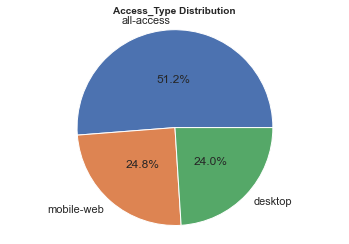

In [28]:
x = (data["Access_Type"].value_counts(dropna= False, normalize=True) * 100).values
y = (data["Access_Type"].value_counts(dropna= False, normalize=True) * 100).index

plt.pie(x,labels= y,radius=1.5,  autopct='%1.1f%%', pctdistance=0.5 )
plt.title(f'Access_Type Distribution', fontsize = 10, fontweight = 'bold')
plt.axis('equal')
plt.show()

### Exrtacting ACCESS ORIGIN : 

      SPECIFICNAME_LANGUAGE.wikipedia.org_ACCESS TYPE_ ACCESS ORIGIN

In [29]:
data.Page.sample(20)

23185                         Topic:Sbmv1dm6ejjmwetx_www.mediawiki.org_mobile-web_all-agents
71621                                              París_es.wikipedia.org_desktop_all-agents
53518                                   Downton_Abbey_fr.wikipedia.org_mobile-web_all-agents
6051                                             Titanic_fr.wikipedia.org_desktop_all-agents
33712                       Mexico_national_football_team_en.wikipedia.org_all-access_spider
140582                                 Vaginalverkehr_de.wikipedia.org_all-access_all-agents
99020                   Комаров,_Леонид_Александрович_ru.wikipedia.org_all-access_all-agents
13343     Category:1920s_videos_of_male_masturbation_commons.wikimedia.org_all-access_spider
31949                                           重版出来！_zh.wikipedia.org_all-access_all-agents
115808                              Schwarzer_Freitag_de.wikipedia.org_mobile-web_all-agents
108473                                        普密蓬·阿杜德_zh.wikipedia.org

In [30]:
data.Page.str.findall(r'spider|agents').apply(lambda x:x[0]).isna().sum()

0

In [31]:
data["Access_Origin"] =  data.Page.str.findall(r'spider|agents').apply(lambda x:x[0])

In [32]:
data["Access_Origin"].value_counts(dropna= False, normalize=True) * 100

agents    75.932526
spider    24.067474
Name: Access_Origin, dtype: float64

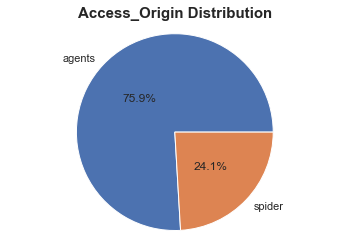

In [33]:
x = (data["Access_Origin"].value_counts(dropna= False, normalize=True) * 100).values
y = (data["Access_Origin"].value_counts(dropna= False, normalize=True) * 100).index

plt.pie(x,labels= y,radius=1.5,  autopct='%1.1f%%', pctdistance=0.5 )
plt.title(f'Access_Origin Distribution', fontsize = 15, fontweight = 'bold')
plt.axis('equal')
plt.show()

In [34]:
data

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

In [35]:
data.groupby("Language").mean()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2016-0

In [36]:
pd.set_option('display.max_rows', 500)


In [37]:
aggregated_data = data.groupby("Language").mean().T.drop("Unknown_Language",axis = 1).reset_index()

In [38]:
aggregated_data["index"] = pd.to_datetime(aggregated_data["index"])
aggregated_data = aggregated_data.set_index("index")

In [39]:
aggregated_data

Language,Chinese,English,French,German,Japenese,Russian,Spanish
index,,,,,,,
2015-07-01,240.582042,3513.862203,475.150994,714.968405,580.647056,629.999601,1085.972919
2015-07-02,240.941958,3502.511407,478.202000,705.229741,666.672801,640.902876,1037.814557
2015-07-03,239.344071,3325.357889,459.837659,676.877231,602.289805,594.026295,954.412680
2015-07-04,241.653491,3462.054256,491.508932,621.145145,756.509177,558.728132,896.050750
2015-07-05,257.779674,3575.520035,482.557746,722.076185,725.720914,595.029157,974.508210
...,...,...,...,...,...,...,...
2016-12-27,376.019618,6040.680728,858.413100,1085.095379,789.158680,1001.209426,1133.367901
2016-12-28,378.048639,5860.227559,774.155769,1032.640804,790.500465,931.987685,1178.290923
2016-12-29,350.719427,6245.127510,752.712954,994.657141,865.483236,897.282452,1112.171085


In [40]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   550 non-null    float64
 1   English   550 non-null    float64
 2   French    550 non-null    float64
 3   German    550 non-null    float64
 4   Japenese  550 non-null    float64
 5   Russian   550 non-null    float64
 6   Spanish   550 non-null    float64
dtypes: float64(7)
memory usage: 34.4 KB


In [41]:
aggregated_data.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'], dtype='datetime64[ns]', name='index', length=550, freq=None)

### Visualising Time  Series for each languages: 

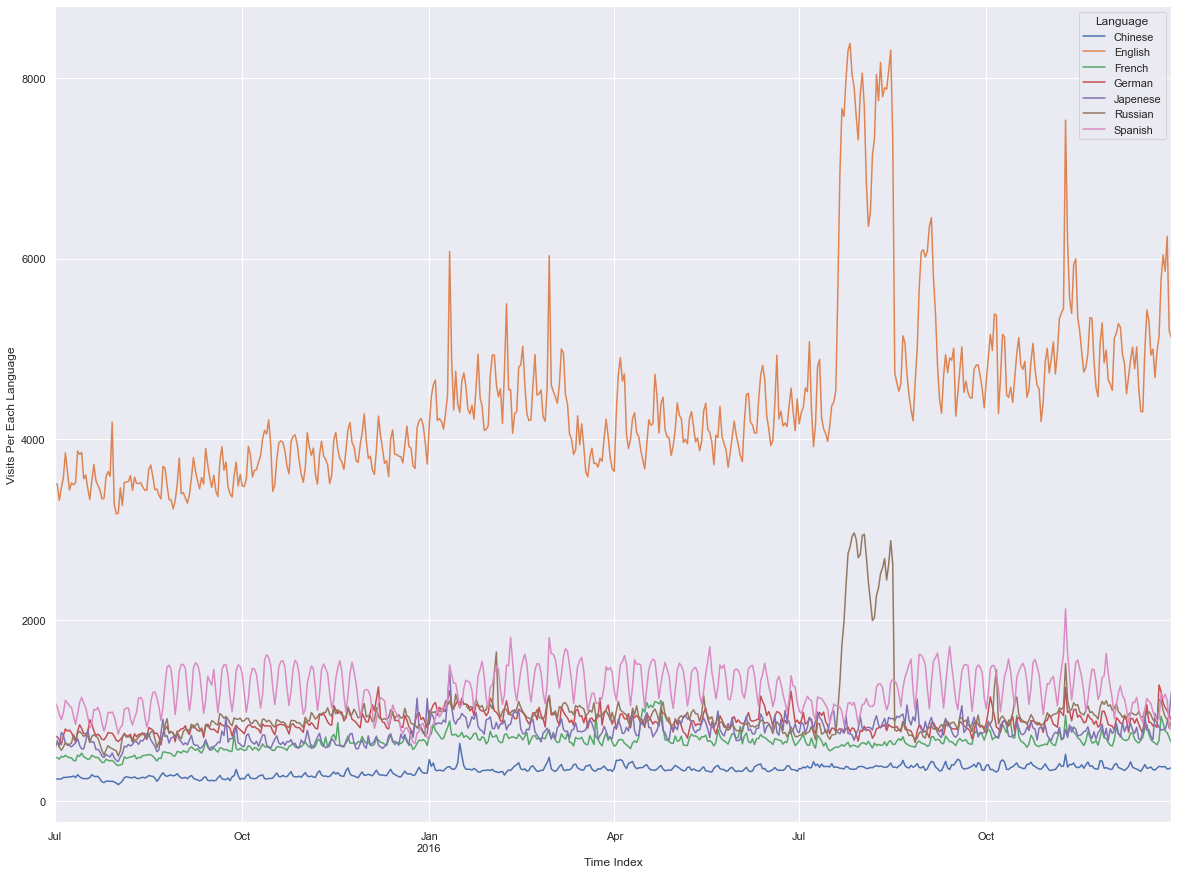

In [42]:
plt.rcParams['figure.figsize'] = (20, 15)

aggregated_data.plot()

plt.xlabel("Time Index")
plt.ylabel("Visits Per Each Language")
plt.show()

## Hypothesis Testing : if Time Series is Stationary or Trending :     


- Null Hypothesis: The series is Non-Stationary
- Alternative Hypothesis: The series is Stationary 

- significant value : 0.05 (alpha)

- if p-value > 0.05 : we failed to reject Null hypothesis: 
  - That means the series is Non-Stationart
- if p-value <= 0.05: we reject Null Hypothesis
 - that means the time series in Stationary


In [43]:
import statsmodels.api as sm

In [44]:
def Dickey_Fuller_test(ts,significances_level = 0.05):
    p_value = sm.tsa.stattools.adfuller(ts)[1]
    if p_value <= significances_level:
        print("Time Series is Stationary")
    else:
        print("Time Series is NOT Stationary")
    print("P_value is: ", p_value)
    

In [45]:
for Language in aggregated_data.columns:
  print(Language)
  print(Dickey_Fuller_test(aggregated_data[Language],significances_level = 0.05))
  print()
  print()
  

Chinese
Time Series is NOT Stationary
P_value is:  0.4474457922931121
None


English
Time Series is NOT Stationary
P_value is:  0.18953359279992338
None


French
Time Series is NOT Stationary
P_value is:  0.05149502195245795
None


German
Time Series is NOT Stationary
P_value is:  0.14097382319729485
None


Japenese
Time Series is NOT Stationary
P_value is:  0.10257133898557613
None


Russian
Time Series is Stationary
P_value is:  0.0018649376536617995
None


Spanish
Time Series is Stationary
P_value is:  0.03358859084479116
None




- Based on DickeyFuller test of Stationarity , we can observe Spanish and Russian languages Pages visits Time series are stationary. 
- Chinese, English , German , Japanese and French are not stationary.

In [46]:
# Further analysing Time Series for English Language Pages Visits : 
TS_English = aggregated_data.English

In [47]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
       df_output['Critical Value (%s)' %key] = value
    print (df_output)

In [48]:
adf_test(TS_English)

Results of Dickey-Fuller Test:
Test Statistic                  -2.247284
p-value                          0.189534
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


In [49]:
Dickey_Fuller_test(TS_English)

Time Series is NOT Stationary
P_value is:  0.18953359279992338


## Visualising English-Language Page Visits Time Series manually to identify seasonality and period :

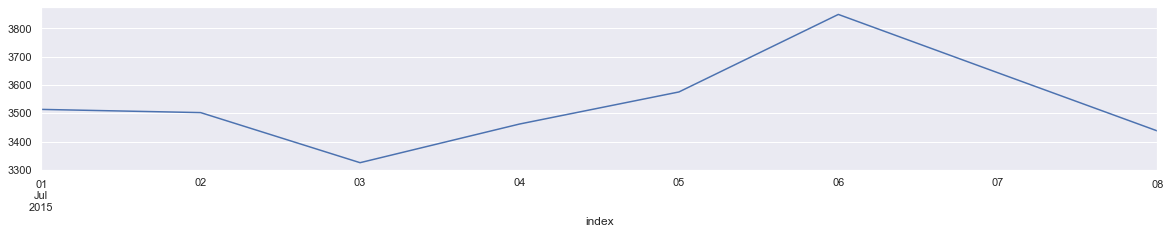

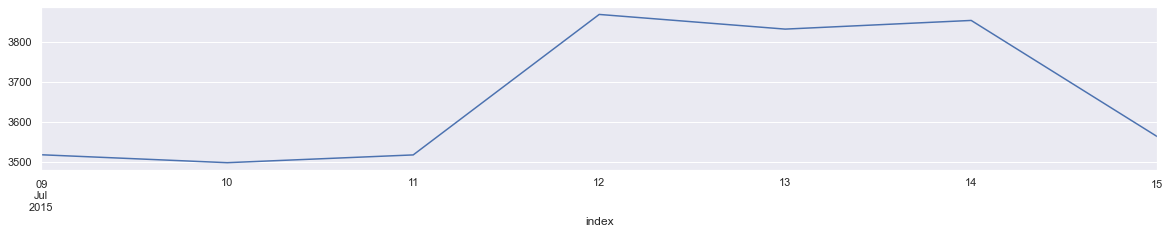

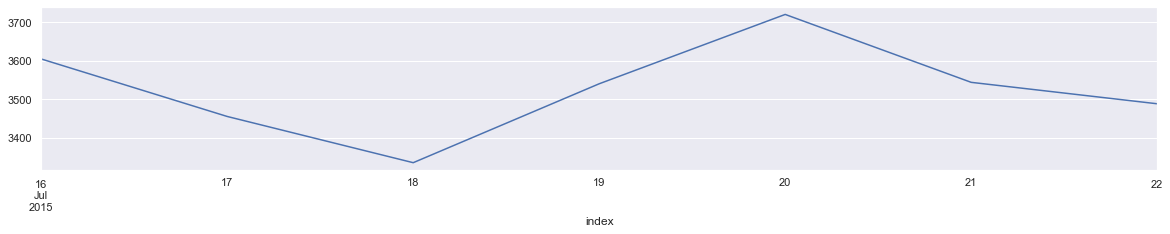

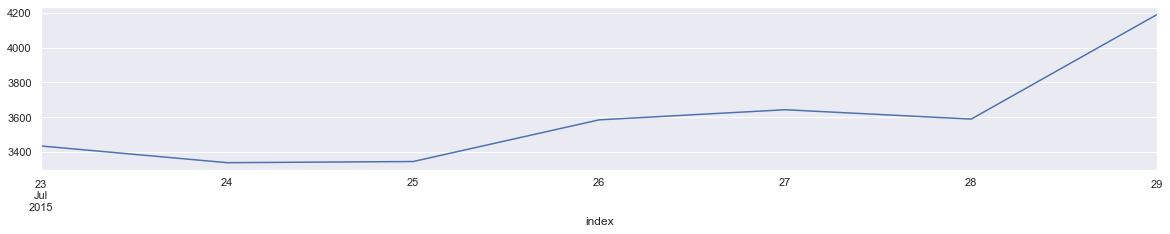

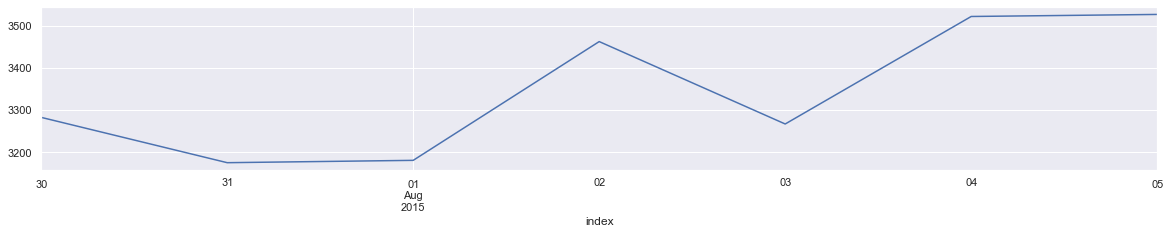

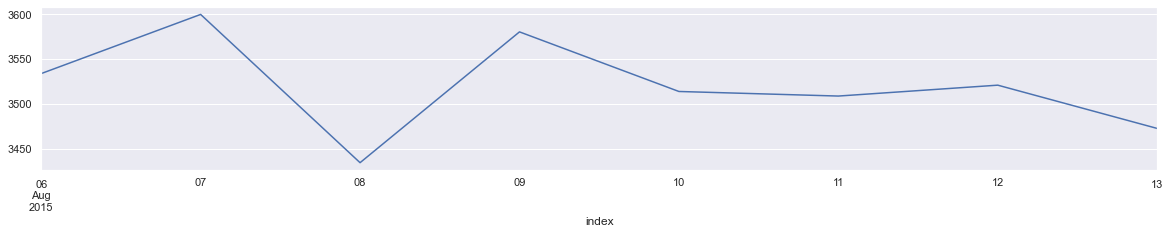

In [50]:
plt.rcParams['figure.figsize'] = (20, 3)

TS_English[:8].plot()
plt.show()
TS_English[8:15].plot()
plt.show()
TS_English[15:22].plot()
plt.show()
TS_English[22:29].plot()
plt.show()
TS_English[29:36].plot()
plt.show()

TS_English[36:44].plot()
plt.show()


# 

# 

In [51]:
correlations = []
for lag in range(1,30):
    present = TS_English[:-lag]
    past = TS_English.shift(-lag)[:-lag]
    corrs = np.corrcoef(present,past)[0][-1]
    print(lag,corrs)
    correlations.append(corrs)

1 0.9363434527458434
2 0.8682966716039892
3 0.8185418037184544
4 0.7846718829500337
5 0.7612561076942569
6 0.7542260641783562
7 0.7386829287516693
8 0.6912638018189878
9 0.6370978014300408
10 0.6015277501876304
11 0.5825450402423569
12 0.581293193479354
13 0.6007266462817786
14 0.6142525351445117
15 0.597108455475553
16 0.5693834937428244
17 0.5488401467532626
18 0.5377431132136111
19 0.5430816743411202
20 0.5552694244923039
21 0.5540623423718064
22 0.5092655604869363
23 0.4537369557681359
24 0.4112336297620323
25 0.3816286061625174
26 0.36519963166994807
27 0.3723603627302602
28 0.3781822668316003
29 0.3593924266732818


## Time Series Decomposition 

          Y(t) = seasonality + trend + residuals 
                    S(t)       + T(t)  + R(t) 

             
             

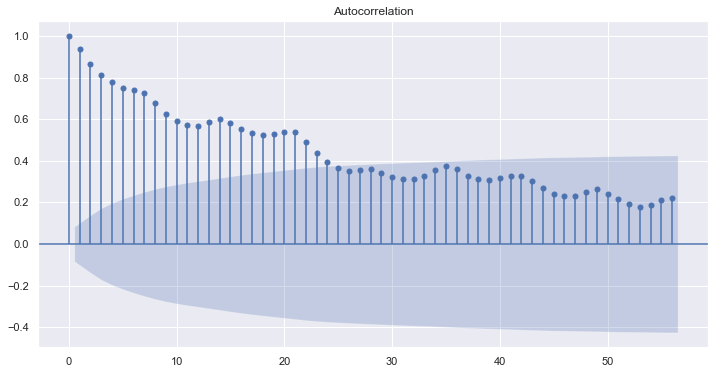

In [52]:
# using auto correlation function plot , to varify the period 

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.rcParams['figure.figsize'] = (12, 6)
plot_acf(TS_English,lags=56);

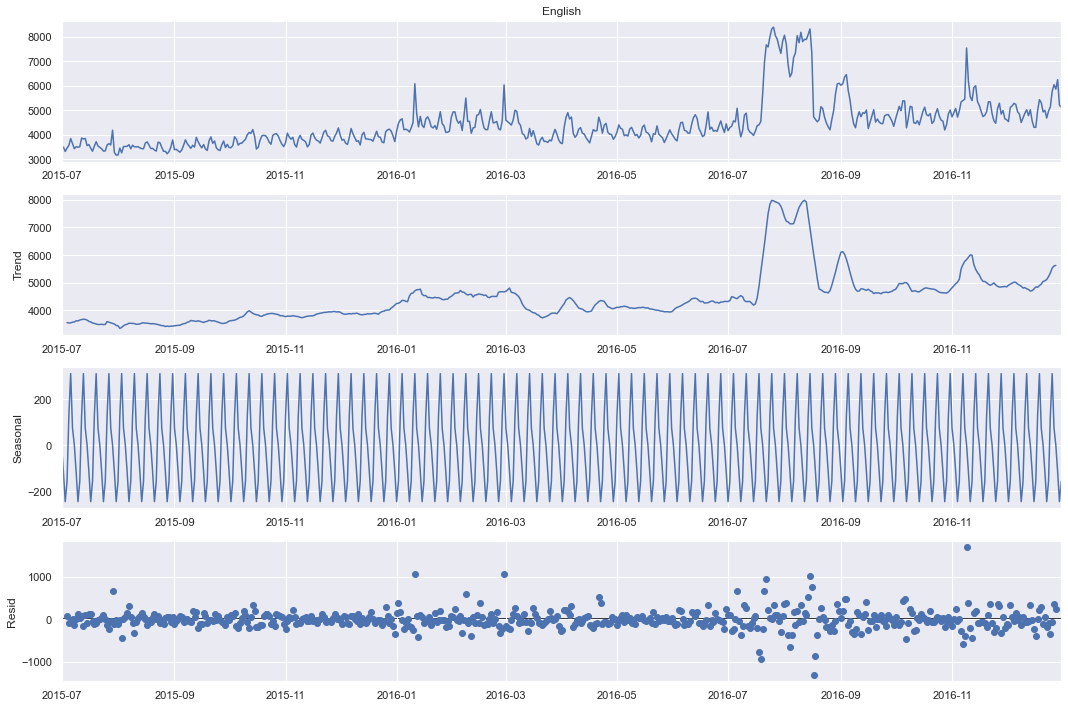

In [53]:
plt.rcParams['figure.figsize'] = (15, 10)

Decomposition_model = sm.tsa.seasonal_decompose(TS_English, model='additive',period=7)
Decomposition_model.plot();

In [54]:
Dickey_Fuller_test(pd.Series(Decomposition_model.resid).fillna(0))

Time Series is Stationary
P_value is:  3.7275269478127076e-21


###### Residuals from time series decomposition are Stationary 

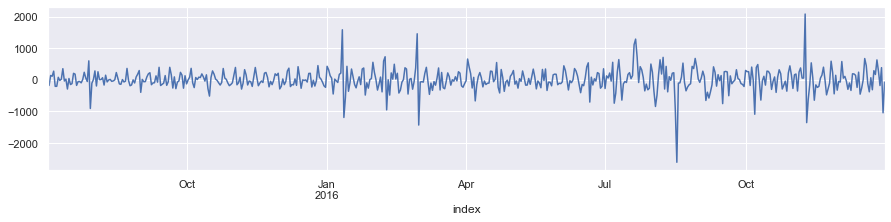

In [55]:
# Taking the first differentiation of the time series and plotting

plt.rcParams['figure.figsize'] = (15, 3)

TS_English.diff(1).dropna().plot()
plt.show()

In [56]:
Dickey_Fuller_test(TS_English.diff(1).dropna())

Time Series is Stationary
P_value is:  5.292474635436461e-13


In [57]:
# After 1 differentiation  , time series becomes stationary.
# Thus for ARIMA models , we can set d = 1

In [58]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

# Forecasting :

### Trying out ExponentialSmoothing Method :  

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


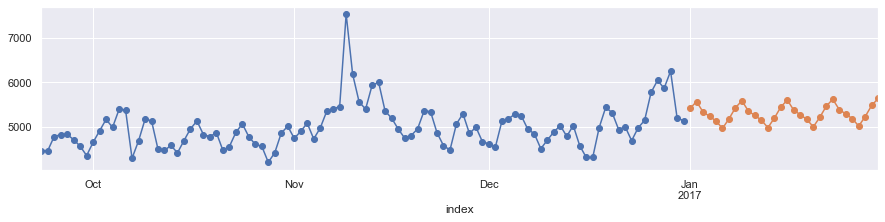

In [60]:
model = sm.tsa.ExponentialSmoothing(TS_English, seasonal='add',trend="add")
model = model.fit()
                                                     # default values
                                                     # of smoothing_level, seasonal_smoothing and 
                                                     # and trend smoothing
    
TS_English.tail(100).plot(style='-o', label='actual')
model.forecast(30).plot(style='-o', label='predicted')
plt.show()

MAE : 401.978
RMSE : 568.473
MAPE: 0.074


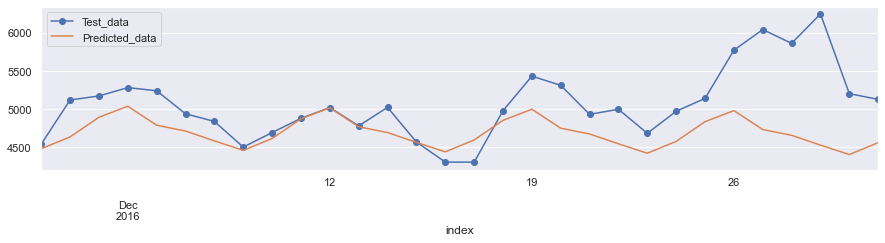

In [61]:
X_train = TS_English.loc[TS_English.index < TS_English.index[-30] ].copy()
X_test = TS_English.loc[TS_English.index >= TS_English.index[-30] ].copy()

import warnings # supress warnings
warnings.filterwarnings('ignore')


model = sm.tsa.ExponentialSmoothing(X_train,
                                    trend="add",
                                    damped_trend="add",
                                    seasonal="add")
model = model.fit(smoothing_level=None,    # alpha
            smoothing_trend=None,          # beta
            smoothing_seasonal=None)       # gama)

# X_test.plot()
Pred = model.forecast(steps=30)
performance(X_test,Pred)

X_test.plot(style="-o",label ="Test_data")
Pred.plot(label="Predicted_data")
plt.legend()
plt.show()

## ARIMA : 

- ####   Autoregressive Integrated Moving Average (ARIMA) model, and extensions

      This model is the basic interface for ARIMA-type models, including those
      with exogenous regressors and those with seasonal components. The most
      general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows
      all specialized cases, including

      autoregressive models: AR(p)

      moving average models: MA(q)

      mixed autoregressive moving average models: ARMA(p, q)

      integration models: ARIMA(p, d, q)

      seasonal models: SARIMA(P, D, Q, s)

      regression with errors that follow one of the above ARIMA-type models



In [62]:
from statsmodels.tsa.arima.model import ARIMA

In [63]:
TS = TS_English.copy(deep=True)

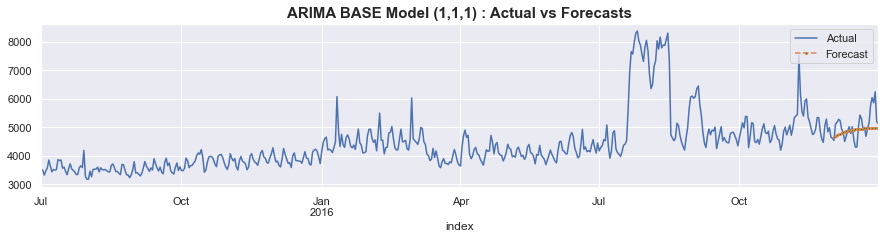


MAPE of Model : 0.06585
RMSE of Model : 472.186


In [64]:
n_forecast = 30


model = ARIMA(TS[:-n_forecast],
              order = (1,1,1))
model = model.fit()

predicted = model.forecast(steps= n_forecast, alpha = 0.05)


TS.plot(label = 'Actual')
predicted.plot(label = 'Forecast', linestyle='dashed', marker='o',markerfacecolor='green', markersize=2)
plt.legend(loc="upper right")
plt.title('ARIMA BASE Model (1,1,1) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()


#Calculating MAPE & RMSE
actuals = TS.values[-n_forecast:]
errors = TS.values[-n_forecast:] - predicted.values

mape = np.mean(np.abs(errors)/ np.abs(actuals))
rmse = np.sqrt(np.mean(errors**2))

print()
print(f'MAPE of Model : {np.round(mape,5)}')

print(f'RMSE of Model : {np.round(rmse,3)}')



### SARIMAX model : 

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_model(time_series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):
    
    #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
    model = SARIMAX(time_series[:-n], \
                    order =(p,d,q), 
                    seasonal_order=(P, D, Q, s), 
                    exog = exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit()
    
    #Creating forecast for last n-values
    model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))
    
    #plotting Actual & Forecasted values
    
    plt.figure(figsize = (20,8))
    time_series[-60:].plot(label = 'Actual')
    model_forecast[-60:].plot(label = 'Forecast', color = 'red', 
                              linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
    plt.show()
    
    #Calculating MAPE & RMSE
    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - model_forecast.values

    mape = np.mean(np.abs(errors)/ np.abs(actuals))
    rmse = np.sqrt(np.mean(errors**2))

    print()
    print(f'MAPE of Model : {np.round(mape,5)}')
    print(f'RMSE of Model : {np.round(rmse,3)}')


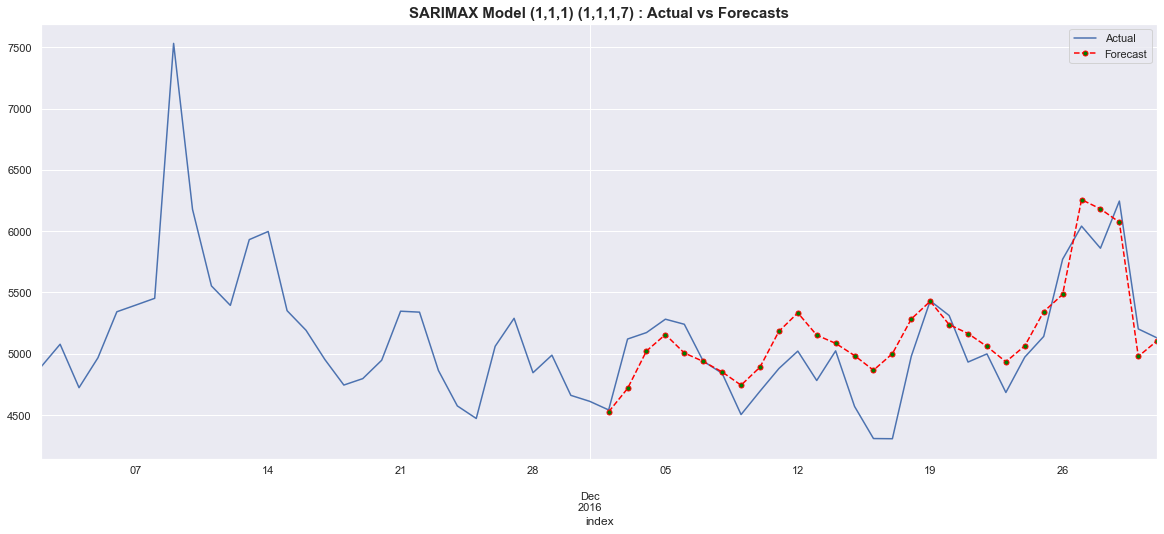


MAPE of Model : 0.0445
RMSE of Model : 272.517


In [67]:
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = aggregated_data.English
test_size= 0.1
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

### Hyperparamer tuning for SARIMAX model 

In [68]:
def SARIMAX_grid_search(time_series, n, param, d_param, s_param, exog = []):
    counter = 0
    #creating df for storing results summary
    param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])
    
    #Creating loop for every paramater to fit SARIMAX model
    for p in param:
        for d in d_param:
            for q in param:
                for P in param:
                    for D in d_param:
                        for Q in param:
                            for s in s_param:
                                #Creating Model
                                model = SARIMAX(time_series[:-n], 
                                                order=(p,d,q), 
                                                seasonal_order=(P, D, Q, s), 
                                                exog = exog[:-n],
                                                initialization='approximate_diffuse')
                                model_fit = model.fit()
                                
                                #Creating forecast from Model
                                model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))
                                
                                #Calculating errors for results
                                actuals = time_series.values[-n:]
                                errors = time_series.values[-n:] - model_forecast.values
                                
                                #Calculating MAPE & RMSE
                                mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                rmse = np.sqrt(np.mean(errors**2))
                                mape = np.round(mape,5)
                                rmse = np.round(rmse,3)
                                
                                #Storing the results in param_df
                                counter += 1
                                list_row = [counter, (p,d,q), (P,D,Q,s), mape, rmse]
                                param_df.loc[len(param_df)] = list_row
                                
                #print statement to check progress of Loop                
                print(f'Possible Combination: {counter} out of { (len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')
                           
    return param_df     

In [69]:
#Finding best parameters for English time series

exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = aggregated_data.English
n = 30
param = [0,1,2]
d_param = [0,1]
s_param = [7]

english_params  = SARIMAX_grid_search(time_series, n, param, d_param,s_param, exog)

Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 out of 324 calculated


In [70]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
323,324,"(2, 1, 2)","(2, 1, 2, 7)",0.03999,248.472
317,318,"(2, 1, 2)","(1, 1, 2, 7)",0.04062,247.518
214,215,"(1, 1, 2)","(2, 1, 1, 7)",0.04156,255.399
40,41,"(0, 0, 2)","(0, 1, 1, 7)",0.04199,276.311
41,42,"(0, 0, 2)","(0, 1, 2, 7)",0.04206,271.577


In [71]:
# best possible parameters : p,d,q,P,D,Q,s = 2,1,2,1,1,2,7

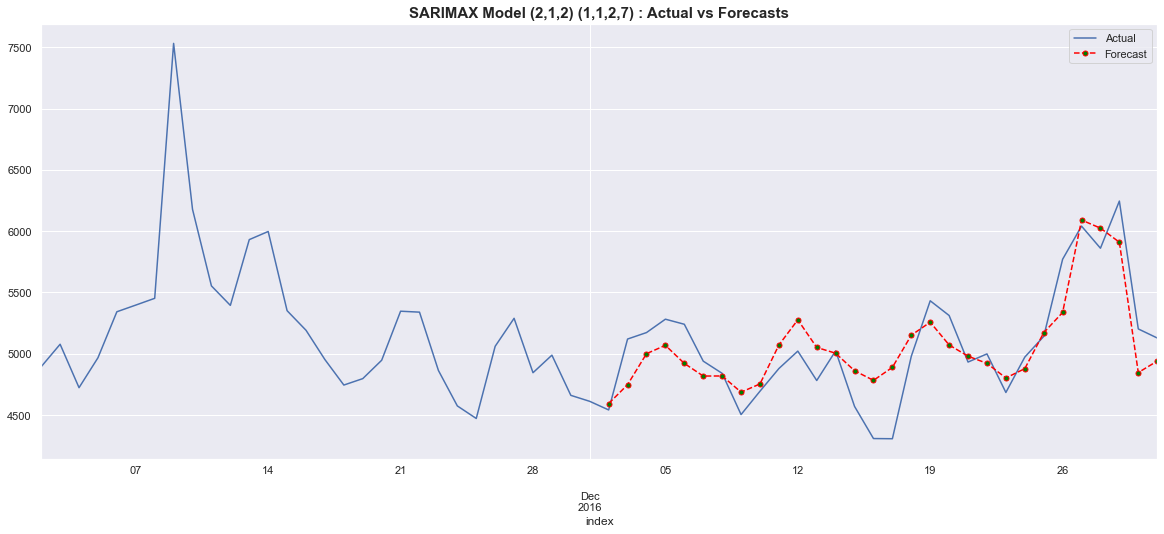


MAPE of Model : 0.04062
RMSE of Model : 247.518


In [72]:
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = aggregated_data.English
test_size= 0.1
p,d,q, P,D,Q,s = 2,1,2,1,1,2,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

## Hyperparameter tuning for all other languages : 

In [73]:
def pipeline_sarimax_grid_search_without_exog(languages, data, n, param, d_param, s_param):
    
    best_param_df  = pd.DataFrame(columns = ['language','p','d', 'q', 'P','D','Q','s','mape'])
    for lang in languages:
        print('')
        print('')
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        counter = 0
        time_series = data[lang]
        best_mape = 100
        
        #Creating loop for every paramater to fit SARIMAX model
        for p in param:
            for d in d_param:
                for q in param:
                    for P in param:
                        for D in d_param:
                            for Q in param:
                                for s in s_param:
                                    #Creating Model
                                    model = SARIMAX(time_series[:-n], 
                                                    order=(p,d,q), 
                                                    seasonal_order=(P, D, Q, s), 
                                                    initialization='approximate_diffuse')
                                    model_fit = model.fit()

                                    #Creating forecast from Model
                                    model_forecast = model_fit.forecast(n, dynamic = True)

                                    #Calculating errors for results
                                    actuals = time_series.values[-n:]
                                    errors = time_series.values[-n:] - model_forecast.values

                                    #Calculating MAPE & RMSE
                                    mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                    
                                    counter += 1

                                    if (mape < best_mape):
                                        best_mape = mape
                                        best_p = p
                                        best_d = d
                                        best_q = q
                                        best_P = P
                                        best_D = D
                                        best_Q = Q
                                        best_s = s
                                    else: pass

                    #print statement to check progress of Loop                
                    print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 5)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')
        
        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row                
                           
    return best_param_df

In [74]:
languages = aggregated_data.columns
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]


best_param_df = pipeline_sarimax_grid_search_without_exog(languages, aggregated_data, n, param, d_param, s_param)



--------------------------------------------------------------
          Finding best parameters for Chinese                  
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculat

# 

In [76]:
def plot_best_SARIMAX_model(languages, data, n, best_param_df):
    
    for lang in languages:
        #fetching respective best parameters for that language
        p = best_param_df.loc[best_param_df['language'] == lang, ['p']].values[0][0]
        d = best_param_df.loc[best_param_df['language'] == lang, ['d']].values[0][0]
        q = best_param_df.loc[best_param_df['language'] == lang, ['q']].values[0][0]
        P = best_param_df.loc[best_param_df['language'] == lang, ['P']].values[0][0]
        D = best_param_df.loc[best_param_df['language'] == lang, ['D']].values[0][0]
        Q = best_param_df.loc[best_param_df['language'] == lang, ['Q']].values[0][0]
        s = best_param_df.loc[best_param_df['language'] == lang, ['s']].values[0][0]
        
        #Creating language time-series
        time_series = data[lang]
        
        #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
        model = SARIMAX(time_series[:-n], 
                        order =(p,d,q), 
                        seasonal_order=(P, D, Q, s),
                        initialization='approximate_diffuse')
        model_fit = model.fit()
        
        #Creating forecast for last n-values
        model_forecast = model_fit.forecast(n, dynamic = True)
        
        #Calculating MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values

        mape = np.mean(np.abs(errors)/ np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))
        
        print('')
        print('')
        print(f'-----------------------------------------------------------------------------------------')
        print(f'        SARIMAX model for {lang} Time Series                                             ')
        print(f'        Parameters of Model : ({p},{d},{q}) ({P},{D},{Q},{s})                            ')
        print(f'        MAPE of Model       : {np.round(mape,5)}                                         ')
        print(f'        RMSE of Model       : {np.round(rmse,3)}                                         ')
        print(f'-----------------------------------------------------------------------------------------')
        
        #plotting Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize = (20,8))
        time_series[-60:].plot(label = 'Actual')
        model_forecast[-60:].plot(label = 'Forecast', color = 'red', 
                                  linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
        plt.legend(loc="upper right")
        plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
        plt.show()
    
    return 0



-----------------------------------------------------------------------------------------
        SARIMAX model for Chinese Time Series                                             
        Parameters of Model : (0,1,0) (1,0,2,7)                            
        MAPE of Model       : 0.03074                                         
        RMSE of Model       : 14.487                                         
-----------------------------------------------------------------------------------------


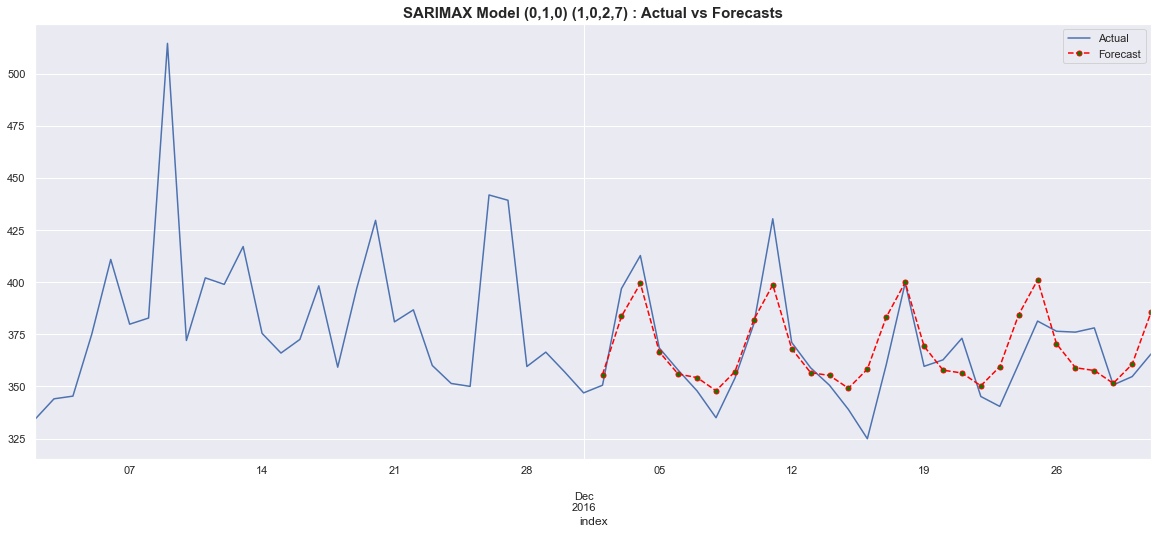



-----------------------------------------------------------------------------------------
        SARIMAX model for English Time Series                                             
        Parameters of Model : (2,0,1) (0,1,2,7)                            
        MAPE of Model       : 0.05244                                         
        RMSE of Model       : 383.218                                         
-----------------------------------------------------------------------------------------


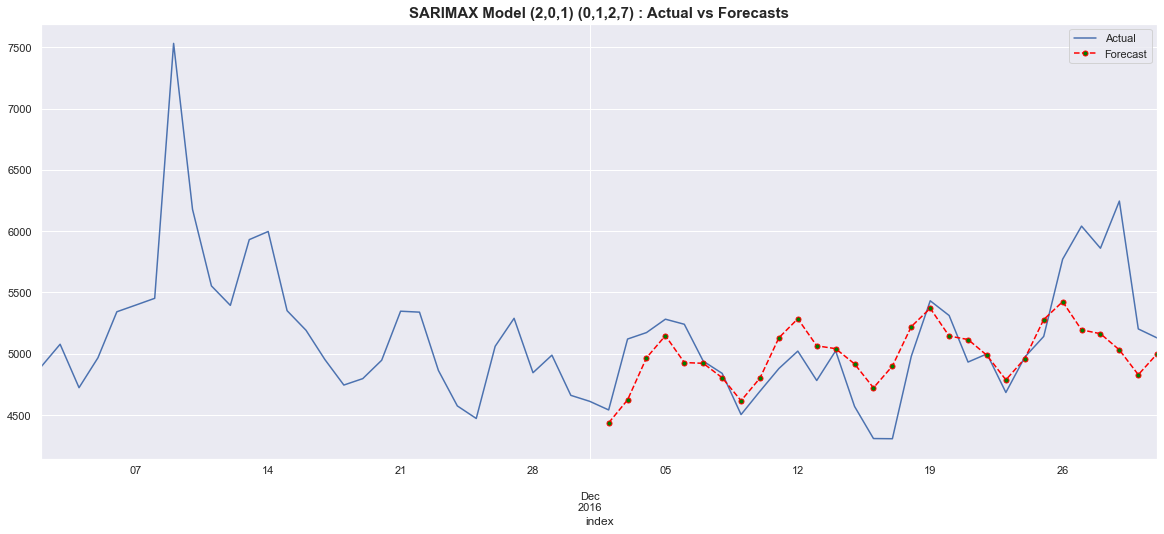



-----------------------------------------------------------------------------------------
        SARIMAX model for French Time Series                                             
        Parameters of Model : (0,0,2) (2,1,2,7)                            
        MAPE of Model       : 0.06361                                         
        RMSE of Model       : 72.602                                         
-----------------------------------------------------------------------------------------


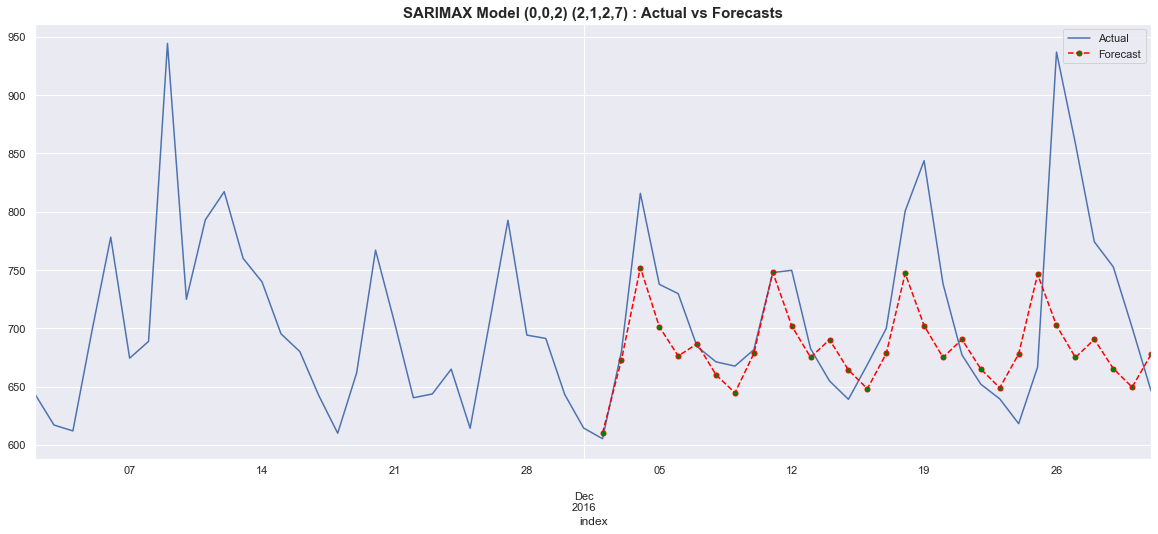



-----------------------------------------------------------------------------------------
        SARIMAX model for German Time Series                                             
        Parameters of Model : (0,1,1) (1,0,1,7)                            
        MAPE of Model       : 0.06578                                         
        RMSE of Model       : 110.621                                         
-----------------------------------------------------------------------------------------


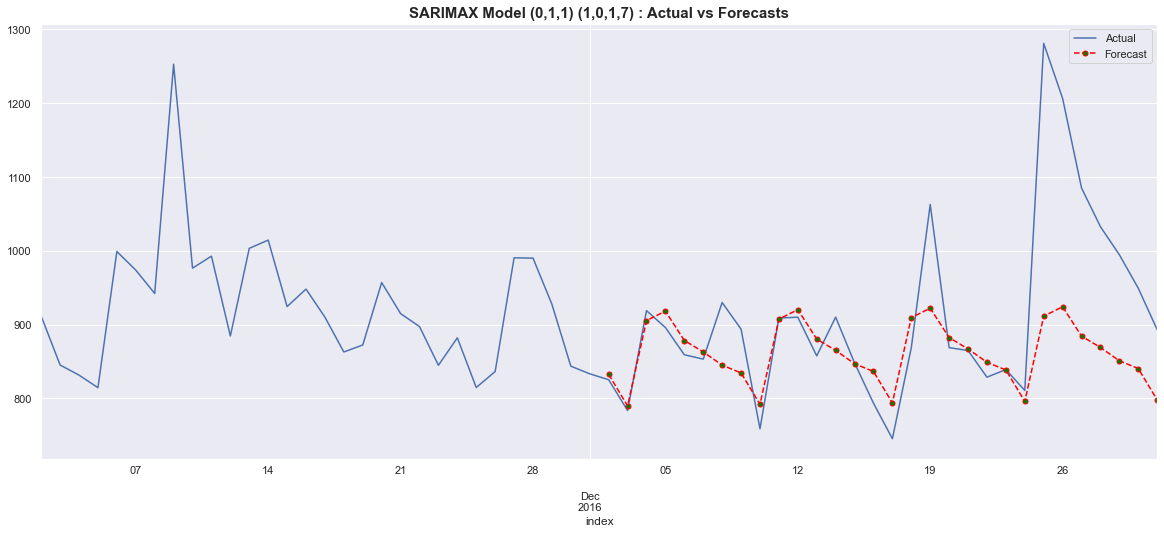



-----------------------------------------------------------------------------------------
        SARIMAX model for Japenese Time Series                                             
        Parameters of Model : (0,1,2) (2,1,0,7)                            
        MAPE of Model       : 0.07122                                         
        RMSE of Model       : 90.833                                         
-----------------------------------------------------------------------------------------


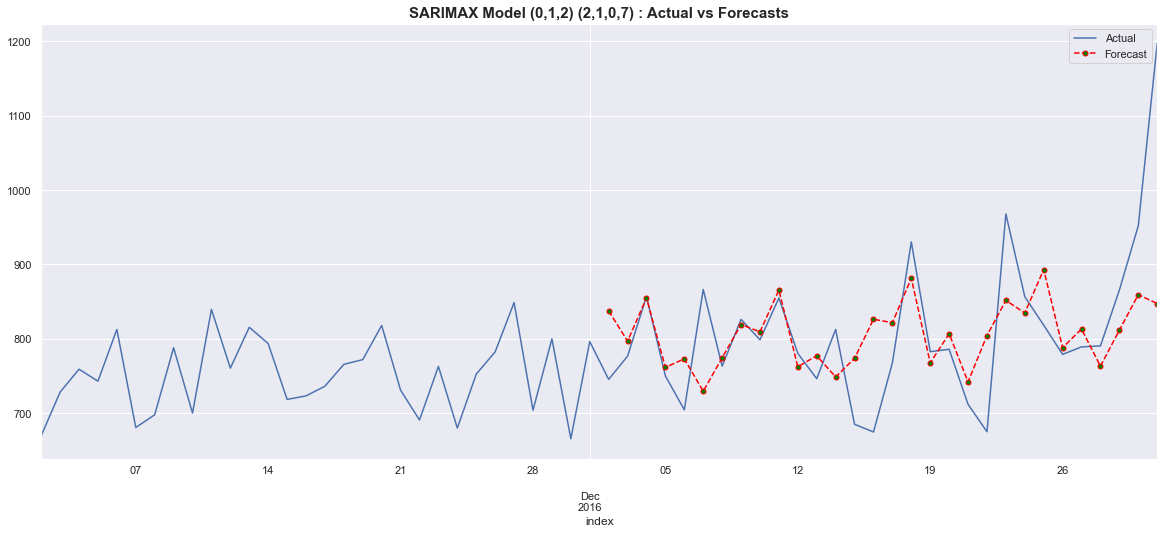



-----------------------------------------------------------------------------------------
        SARIMAX model for Russian Time Series                                             
        Parameters of Model : (0,0,1) (2,0,2,7)                            
        MAPE of Model       : 0.04306                                         
        RMSE of Model       : 56.813                                         
-----------------------------------------------------------------------------------------


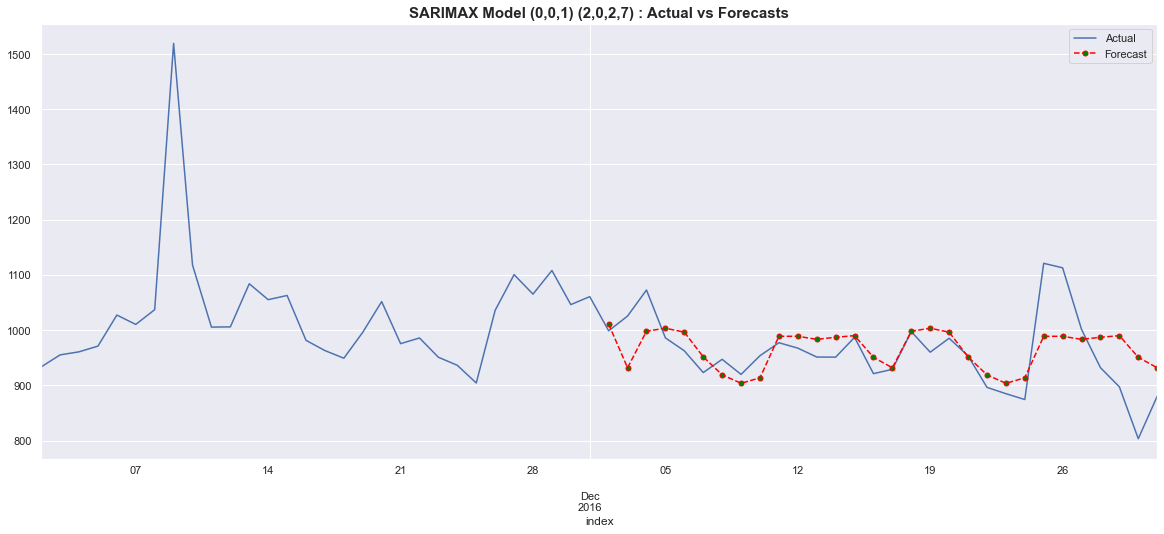



-----------------------------------------------------------------------------------------
        SARIMAX model for Spanish Time Series                                             
        Parameters of Model : (0,1,0) (2,1,0,7)                            
        MAPE of Model       : 0.08561                                         
        RMSE of Model       : 109.03                                         
-----------------------------------------------------------------------------------------


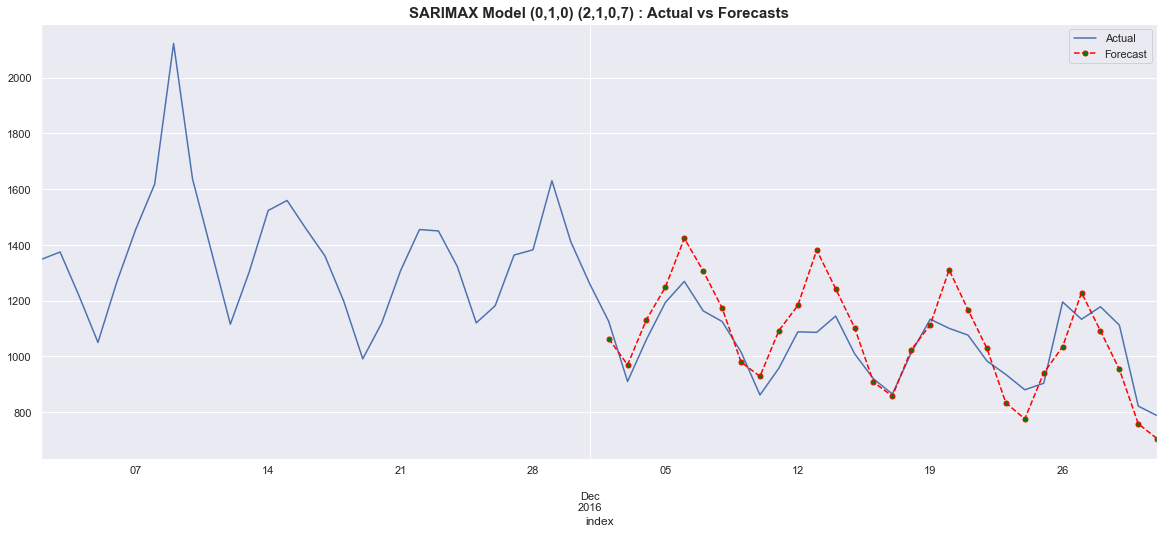

0

In [77]:
#Plotting SARIMAX model for each Language Time Series
languages = aggregated_data.columns
n = 30 
plot_best_SARIMAX_model(languages, aggregated_data, n, best_param_df)

# 

# 

# 

# 

# 

# 

# Forecasting using Facebook Prophet : 

In [ ]:
from fbprophet import Prophet

In [ ]:
time_series = aggregated_data
time_series = time_series.reset_index()
time_series = time_series[['index', 'English']]
time_series.columns = ['ds', 'y']
exog = Exog_Campaign_eng.copy(deep = True)
time_series['exog'] = exog.values

In [ ]:
time_series

,ds,y,exog
0,2015-07-01,3513.862203,0
1,2015-07-02,3502.511407,0
2,2015-07-03,3325.357889,0
3,2015-07-04,3462.054256,0
4,2015-07-05,3575.520035,0
...,...,...,...
545,2016-12-27,6040.680728,1
546,2016-12-28,5860.227559,1
547,2016-12-29,6245.127510,1
548,2016-12-30,5201.783018,0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


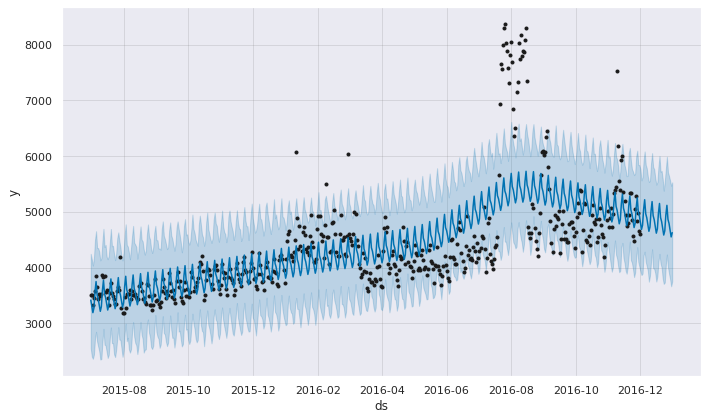

In [ ]:
prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(time_series[['ds', 'y']][:-30])
future = prophet1.make_future_dataframe(periods=30, freq= 'D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


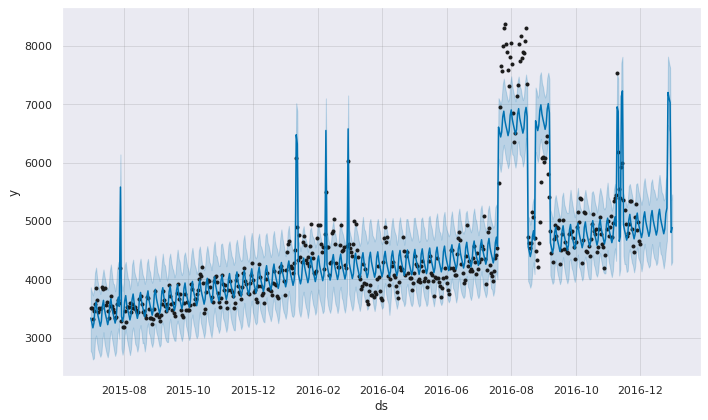

In [ ]:
prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('exog')
prophet2.fit(time_series[:-30])
#future2 = prophet2.make_future_dataframe(periods=30, freq= 'D')
forecast2 = prophet2.predict(time_series)
fig2 = prophet2.plot(forecast2)

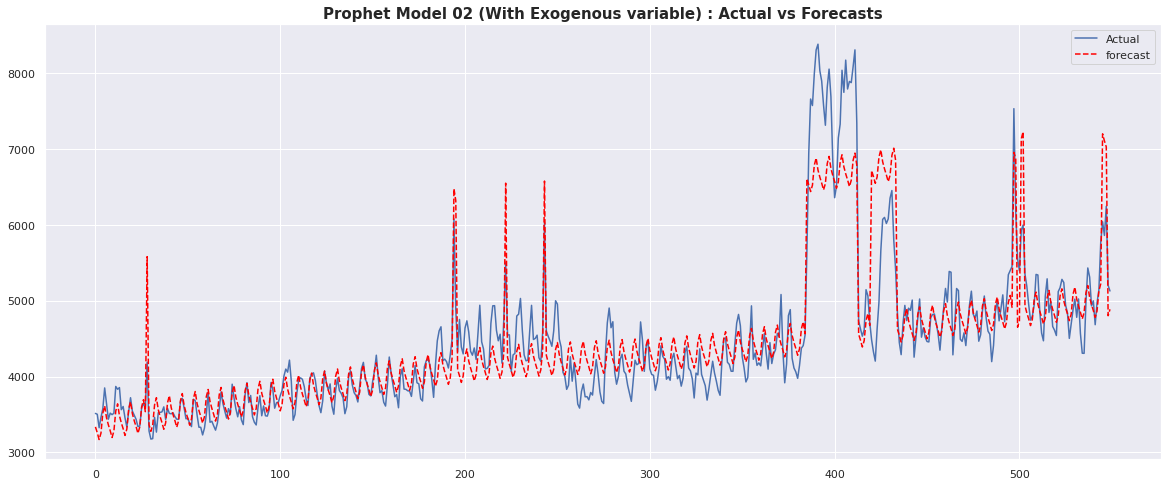

In [ ]:
actual = time_series['y'].values
forecast = forecast2['yhat'].values

plt.figure(figsize = (20,8))
plt.plot(actual, label = 'Actual')
plt.plot(forecast, label = 'forecast', color = 'red', linestyle='dashed')
plt.legend(loc="upper right")
plt.title(f'Prophet Model 02 (With Exogenous variable) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

In [ ]:
errors = abs(actual - forecast)
mape = np.mean(errors/abs(actual))
mape

0.0594578640110275

# Inferences and Recommendations : 

- inferences made from the data visualizations:

  - Total 7 languages found in data.
  - English has the highest number of pages.



  - 3 access types:
    - all-access    51.2295 %
    - mobile-web    24.7748 %
    - desktop       23.9958 %


  - 2 access origins:
    - agents    75.932526 %
    - spider    24.067474 %
    


  - English language has the highest pages. 
  - Maximum ads should be run on English Page. 



- What does the decomposition of series do?
  - The decomposition of a time series refers to the process of separating a time series into its components, such as trend, seasonality, and residuals. 
  - These components are intended to represent different underlying patterns in the data. The idea behind decomposition is to break down a complex time series into simpler components that can be more easily understood and analyzed.

  - Trend component represents the underlying pattern in the data over time, reflecting long-term changes.
  -  Seasonality component represents regular patterns that repeat over a fixed interval, such as daily, weekly, or yearly.
  -  Residual component represents the remaining random fluctuations in the data after removing the trend and seasonality components.
  - Decomposition is often used in time series analysis to identify and isolate different patterns in the data and to forecast future values. It is also used to remove seasonality and trend components from the data before applying statistical or machine learning models to the residuals, as this can help to improve the performance of these models.
  - .
  




- What level of differencing gave you a stationary series?

  - Stationarity is an important property of a time series because many time series analysis techniques assume that the time series is stationary.
  -  A time series is stationary if its mean, variance, and autocorrelation structure are constant over time.
  - Differencing is a common technique used to make a time series stationary. 
  - It involves subtracting the value of the time series at a previous time step from the current time step. 
  - This can help to remove trend and seasonality components from the data, making it more stationary. 
  - The order of differencing refers to the number of times the differencing operation is performed.
  - in this case study, differencing once yield a stationary time series.



---
- Difference between arima, sarima & sarimax.
---
  - ARIMA (AutoRegressive Integrated Moving Average) is a statistical model for time series data that accounts for both autoregression (the use of past values to predict future values) and moving average (the use of the residuals of past predictions to predict future values). 
  - It is a flexible method for modeling non-stationary time series data and can be used for both univariate and multivariate time series. 
  - ARIMA models are denoted by the notations ARIMA(p, d, q), where p is the order of the autoregression component, d is the order of differencing used to make the time series stationary, and q is the order of the moving average component.
---
  - SARIMA (Seasonal AutoRegressive Integrated Moving Average) is a variation of ARIMA that accounts for both seasonality and non-stationarity in time series data.
  - Seasonality refers to repeating patterns in the data over fixed time intervals, such as daily, weekly, or yearly. SARIMA models are denoted by the notations SARIMA(p, d, q)(P, D, Q, S), where p, d, and q are the same as in ARIMA models, P is the order of the seasonal autoregression component, D is the order of seasonal differencing, Q is the order of the seasonal moving average component, and S is the number of seasons in the data.
---
  - SARIMAX (Seasonal AutoRegressive Integrated Moving Average with exogenous regressors) is an extension of SARIMA that allows for the inclusion of exogenous variables, or variables that are not part of the time series data, in the modeling process.
  - SARIMAX models are useful when the time series data is influenced by other variables that are not part of the time series data, and can provide more accurate forecasts. 
  - SARIMAX models are denoted by the notations SARIMAX(p, d, q)(P, D, Q, S)x, where p, d, q, P, D, Q, and S are the same as in SARIMA models and x represents the number of exogenous variables included in the model.
---

- The equation for a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model can be expressed as follows:

      ARIMA(p, d, q)(P, D, Q, S):

         y(t) = c + φ1 * y(t-1) + φ2 * y(t-2) + ... + φp * y(t-p) 
                  + Θ1 * e(t-1) + Θ2 * e(t-2) + ... + Θq * e(t-q) 
                  + δ * y(t-S) + Φ1 * y(t-S-1) + Φ2 * y(t-S-2) + ... + ΦP * y(t-S-P) 
                  + Θ1 * e(t-S-1) + Θ2 * e(t-S-2) + ... + ΘQ * e(t-S-Q) + e(t)

                where:

                y(t) is the value of the time series at time step t.
                c is a constant.
                φ1, φ2, ..., φp are the autoregression coefficients.
                Θ1, Θ2, ..., Θq are the moving average coefficients.
                δ is a coefficient for the seasonal autoregression term.
                Φ1, Φ2, ..., ΦP are the seasonal autoregression coefficients.
                Θ1, Θ2, ..., ΘQ are the seasonal moving average coefficients.
                e(t), e(t-1), ..., e(t-q), e(t-S), e(t-S-1), ..., e(t-S-Q) are the residuals.
       - In a SARIMA model, the order of differencing (d) is used to make the time series stationary,
        the autoregression and moving average components (p and q) are used to model the autocorrelation structure of the residuals, 
        and the seasonal components (P, D, Q, and S) are used to model the seasonal patterns in the data.
         The coefficients in the model are estimated using maximum likelihood estimation or other optimization techniques,
          and the residuals are used to assess the goodness-of-fit of the model.


- Compare the number of views in different languages




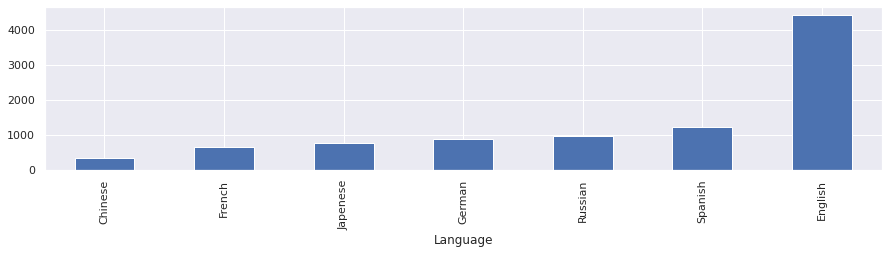

In [ ]:
aggregated_data.mean().sort_values().plot(kind = 'bar')



- What other methods other than grid search would be suitable to get the model for all languages?

  - When estimating the values of p, q, and d from the ACF and PACF plots of a time series, the following steps can be taken:
    - Determine if the time series is stationary by conducting an augmented Dickey-Fuller test.
    - If the time series is stationary, attempt to fit an ARMA model. If it is non-stationary, determine the value of d.
    - If stationarity is achieved, plot the autocorrelation and partial autocorrelation graphs of the data.
    - Plot the partial autocorrelation graph (PACF) to determine the value of p, as the cut-off point in the PACF is equal to p.
    - Plot the autocorrelation graph (ACF) to determine the value of q, as the cut-off point in the ACF is equal to q

--- 